In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import numpy as np
import torch
from pathlib import Path
import sys
import os

In [20]:
sys.path.append('../')
from fovea_lib.transforms import FovealTransform, visualize_foveal_sampling
from fovea_lib.metrics import EfficiencyMetrics

Visualizing raw experimental data...


100%|██████████| 170498071/170498071 [00:20<00:00, 8214036.74it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
=== RAW DATA INSPECTION ===
Batch size: 8
Glimpses tensor shape: torch.Size([8, 3, 3, 16, 16])
Full images shape: torch.Size([8, 3, 32, 32])
Labels: tensor([6, 3, 4, 9, 9, 1, 7, 0])


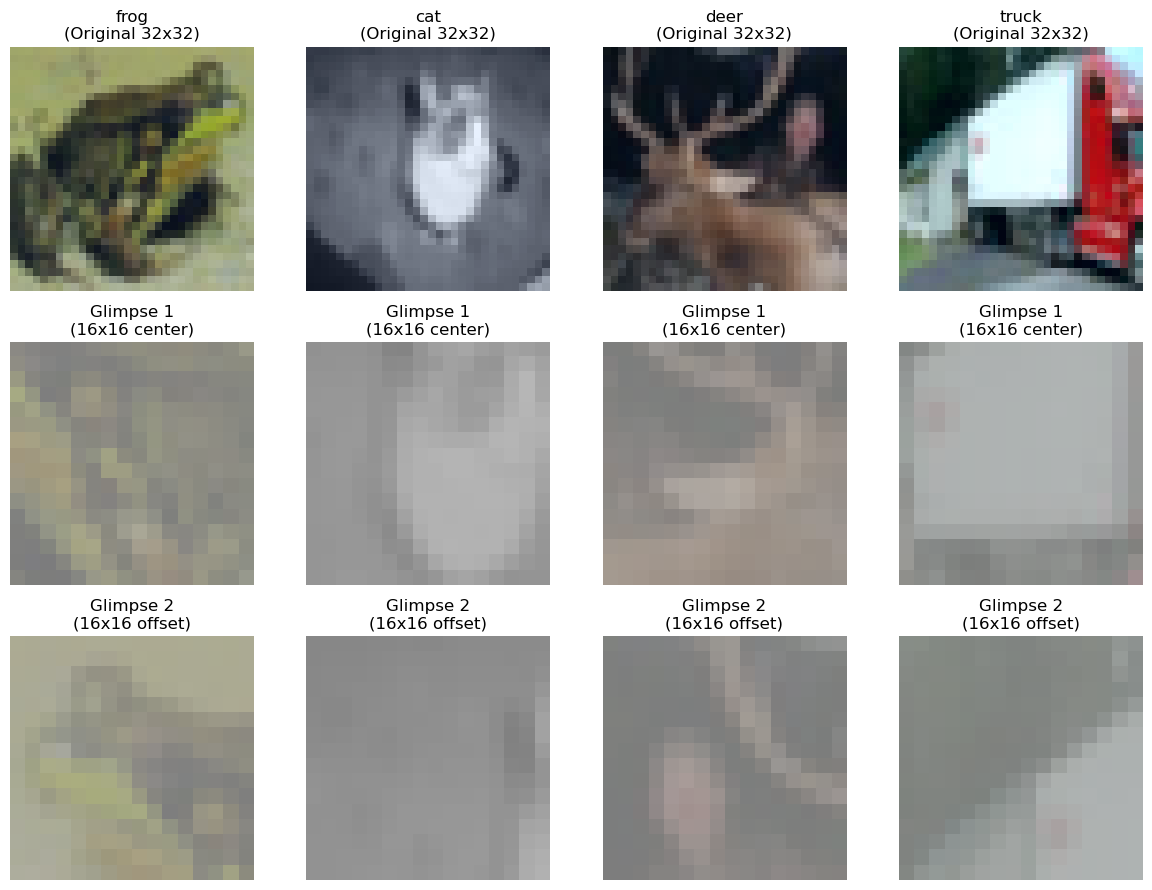


Fixed glimpse locations: [(16, 16), (8, 8), (24, 24)]


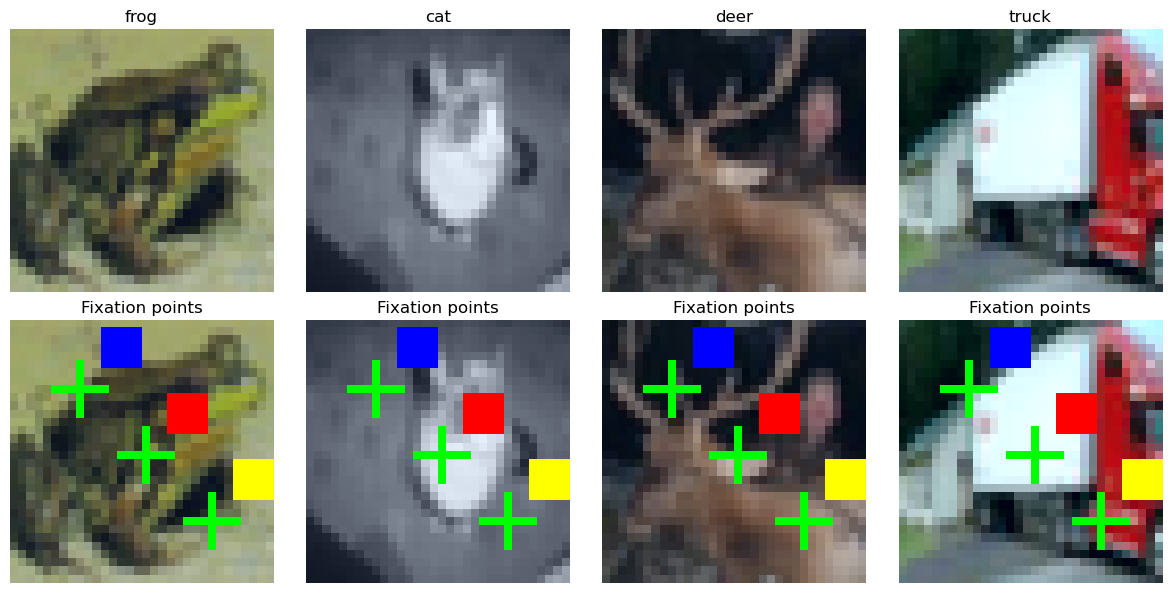

Files already downloaded and verified
Files already downloaded and verified

=== DATASET STATISTICS ===
Training batches: 1563
Test batches: 313
Training samples: 50000
Test samples: 10000

Pixel value ranges:
Glimpses: [0.000, 1.000]
Full images: [-2.118, 2.640]

Memory usage:
Glimpses tensor: 288.0 KB
Full images tensor: 384.0 KB

Pixels processed per image:
Glimpses: 2304 pixels (3 × 16×16×3)
Full image: 3072 pixels (32×32×3)
Reduction factor: 1.3x


In [21]:


from fovea_lib.dataset_builder import create_baseline_dataloaders
from fovea_lib.transforms import visualize_foveal_sampling, FovealTransform

def show_raw_data_samples():
    """Show what the raw dataset looks like."""
    
    # Load dataset
    train_loader, test_loader = create_baseline_dataloaders(
        dataset_name='cifar10',
        data_dir='./data', 
        n_glimpses=3,
        batch_size=8
    )
    
    # Get one batch
    glimpses, full_images, labels = next(iter(train_loader))
    
    print("=== RAW DATA INSPECTION ===")
    print(f"Batch size: {glimpses.shape[0]}")
    print(f"Glimpses tensor shape: {glimpses.shape}")  # (batch, n_glimpses, C, H, W)
    print(f"Full images shape: {full_images.shape}")   # (batch, C, H, W)
    print(f"Labels: {labels}")
    
    # CIFAR-10 class names
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Show first 4 samples
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    
    for i in range(4):
        # Original full image
        img = full_images[i].permute(1, 2, 0).numpy()
        img = (img * 0.229 + 0.485).clip(0, 1)  # denormalize
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'{classes[labels[i]]}\n(Original 32x32)')
        axes[0, i].axis('off')
        
        # Glimpses (3 per image)
        glimpse1 = glimpses[i, 0].permute(1, 2, 0).numpy()
        glimpse1 = (glimpse1 * 0.229 + 0.485).clip(0, 1)
        axes[1, i].imshow(glimpse1)
        axes[1, i].set_title(f'Glimpse 1\n(16x16 center)')
        axes[1, i].axis('off')
        
        glimpse2 = glimpses[i, 1].permute(1, 2, 0).numpy() 
        glimpse2 = (glimpse2 * 0.229 + 0.485).clip(0, 1)
        axes[2, i].imshow(glimpse2)
        axes[2, i].set_title(f'Glimpse 2\n(16x16 offset)')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('raw_data_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Show glimpse locations overlay
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    
    transform = FovealTransform(fovea_radius=8, image_size=32)
    locations = transform.generate_fixed_locations(n_glimpses=3)
    print(f"\nFixed glimpse locations: {locations}")
    
    for i in range(4):
        # Original
        img = full_images[i].permute(1, 2, 0).numpy()
        img = (img * 0.229 + 0.485).clip(0, 1)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'{classes[labels[i]]}')
        axes[0, i].axis('off')
        
        # With fixation overlay
        img_uint8 = (img * 255).astype(np.uint8)
        vis_img = visualize_foveal_sampling(img_uint8, locations, fovea_radius=8)
        axes[1, i].imshow(vis_img)
        axes[1, i].set_title('Fixation points')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('fixation_overlay.png', dpi=150, bbox_inches='tight')
    plt.show()

def show_data_statistics():
    """Show basic statistics about the dataset."""
    
    train_loader, test_loader = create_baseline_dataloaders(
        dataset_name='cifar10',
        data_dir='./data',
        n_glimpses=3, 
        batch_size=32
    )
    
    print("\n=== DATASET STATISTICS ===")
    print(f"Training batches: {len(train_loader)}")
    print(f"Test batches: {len(test_loader)}")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Test samples: {len(test_loader.dataset)}")
    
    # Pixel statistics
    glimpses, full_images, labels = next(iter(train_loader))
    
    print(f"\nPixel value ranges:")
    print(f"Glimpses: [{glimpses.min():.3f}, {glimpses.max():.3f}]")
    print(f"Full images: [{full_images.min():.3f}, {full_images.max():.3f}]")
    
    print(f"\nMemory usage:")
    print(f"Glimpses tensor: {glimpses.element_size() * glimpses.nelement() / 1024:.1f} KB")
    print(f"Full images tensor: {full_images.element_size() * full_images.nelement() / 1024:.1f} KB")
    
    # Computational load
    total_glimpse_pixels = glimpses.shape[1] * glimpses.shape[3] * glimpses.shape[4] * glimpses.shape[2]
    total_full_pixels = full_images.shape[1] * full_images.shape[2] * full_images.shape[3]
    
    print(f"\nPixels processed per image:")
    print(f"Glimpses: {total_glimpse_pixels} pixels (3 × 16×16×3)")
    print(f"Full image: {total_full_pixels} pixels (32×32×3)")
    print(f"Reduction factor: {total_full_pixels / total_glimpse_pixels:.1f}x")

if __name__ == "__main__":
    print("Visualizing raw experimental data...")
    show_raw_data_samples()
    show_data_statistics()